In [1]:
!pip install -q PyGithub
!pip install -q pandas
!pip install -q matplotlib

In [2]:
from github import Github
import pandas as pd
from datetime import datetime
import pandas as pd
import os

import matplotlib.pyplot as plt

token = os.getenv("GITHUB_TOKEN")
# Authenticate with GitHub
g = Github(token)

# Get the repository
repo = g.get_repo("microsoft/terraform-provider-power-platform")

# Compute the average number of review comments per PR by category for AI-assisted vs non-ai-assisted PRs.
prs = []
pulls = repo.get_pulls(state="all")  # query all PRs, not filtering on closed
for pr in pulls:
    if pr.user.login == "dependabot[bot]":
        continue

    is_ai_assisted = any(label.name.lower() == 'ai assisted' for label in pr.labels)
    category = 'ai-assisted' if is_ai_assisted else 'non-ai-assisted'
        # Initialize variable to hold the earliest comment date
    first_comment_at = None

    # Check issue comments
    for comment in pr.get_issue_comments():
        if first_comment_at is None or comment.created_at < first_comment_at:
            first_comment_at = comment.created_at

    # Check review comments
    for comment in pr.get_review_comments():
        if first_comment_at is None or comment.created_at < first_comment_at:
            first_comment_at = comment.created_at

    prs.append({
        'review_comments': pr.review_comments,
        'first_comment_at': first_comment_at,

        'closed_at': pr.closed_at,
        'created_at': pr.created_at,
        'category': category
    })



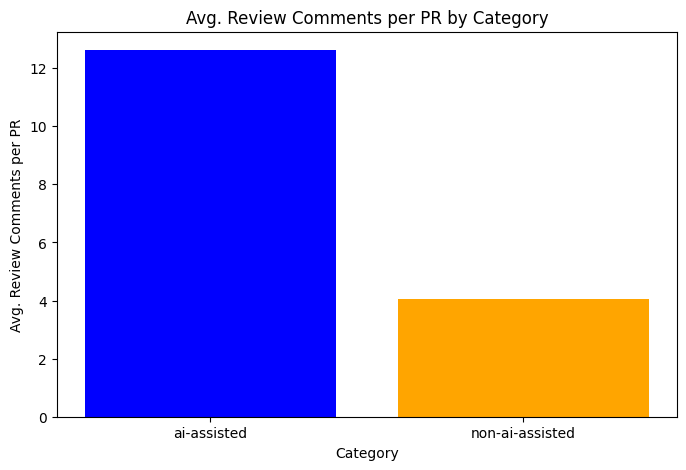

In [3]:
df_reviews = pd.DataFrame(prs)
avg_reviews = df_reviews.groupby('category')['review_comments'].mean().reset_index()

# Plot bar chart with one bar per category
plt.figure(figsize=(8, 5))
plt.bar(avg_reviews['category'], avg_reviews['review_comments'], color=['blue', 'orange'])
plt.xlabel('Category')
plt.ylabel('Avg. Review Comments per PR')
plt.title('Avg. Review Comments per PR by Category')
plt.show()

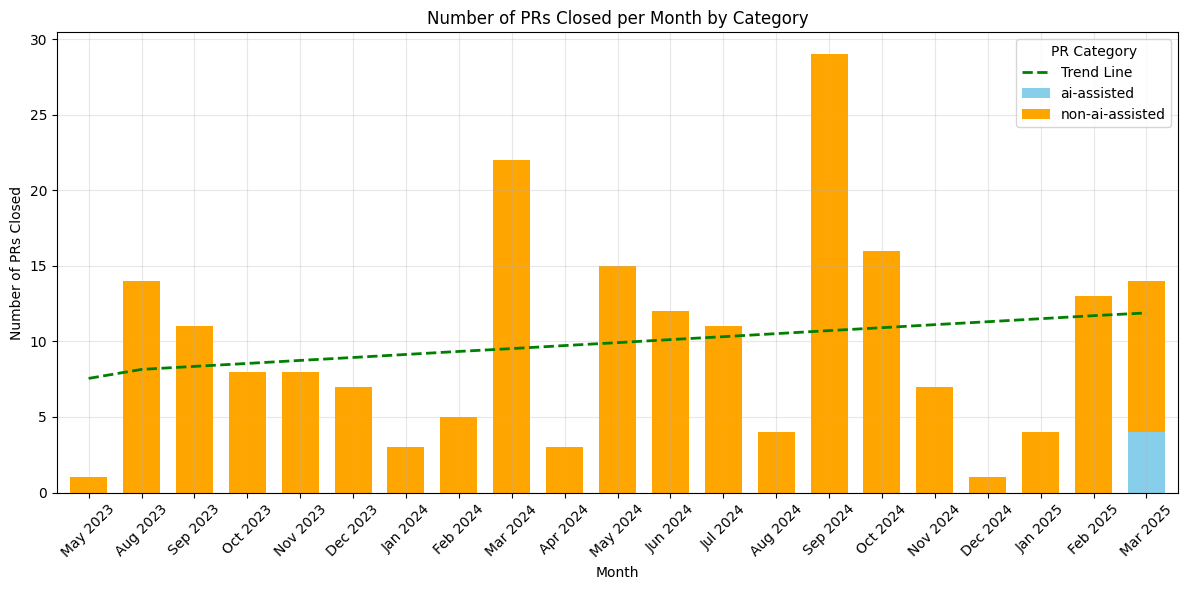

In [23]:
# Extract month from closed_at and count PRs per month, categorized by AI assistance
df['month'] = pd.to_datetime(df['closed_at']).dt.strftime('%Y-%m')
# Group by month and category, then count PRs
monthly_category_counts = df.groupby(['month', 'category']).size().unstack(fill_value=0)

# Convert index to datetime for proper sorting and plotting
monthly_category_counts.index = pd.to_datetime(monthly_category_counts.index + '-01')
monthly_category_counts = monthly_category_counts.sort_index()

# Calculate total counts for rolling average and trendline
monthly_counts = monthly_category_counts.sum(axis=1).reset_index()
monthly_counts.columns = ['month', 'pr_count']

# Calculate 3-month rolling average
rolling_avg = monthly_counts['pr_count'].rolling(window=3).mean()

# Create numeric X values for trendline calculation
x_numeric = np.array([(date - monthly_counts['month'].iloc[0]).days for date in monthly_counts['month']])
y = monthly_counts['pr_count'].values

# Calculate the trendline using polyfit
z = np.polyfit(x_numeric, y, 1)
p = np.poly1d(z)
trendline = p(x_numeric)

# Create the stacked bar chart with lines
plt.figure(figsize=(12, 6))

# Plot stacked bars
monthly_category_counts.plot(kind='bar', stacked=True, ax=plt.gca(), 
                            color=['skyblue', 'orange'], width=0.7)

# Plot rolling average and trendline on secondary axis
#plt.plot(range(len(monthly_counts)), rolling_avg, 'r-', linewidth=2, label='3-Month Rolling Average')
plt.plot(range(len(monthly_counts)), trendline, 'g--', linewidth=2, label='Trend Line')

# Format x-axis labels to Month Year format
ax = plt.gca()
labels = [date.strftime('%b %Y') for date in monthly_category_counts.index]
ax.set_xticklabels(labels)

plt.xlabel('Month')
plt.ylabel('Number of PRs Closed')
plt.title('Number of PRs Closed per Month by Category')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title='PR Category')
plt.tight_layout()
plt.show()


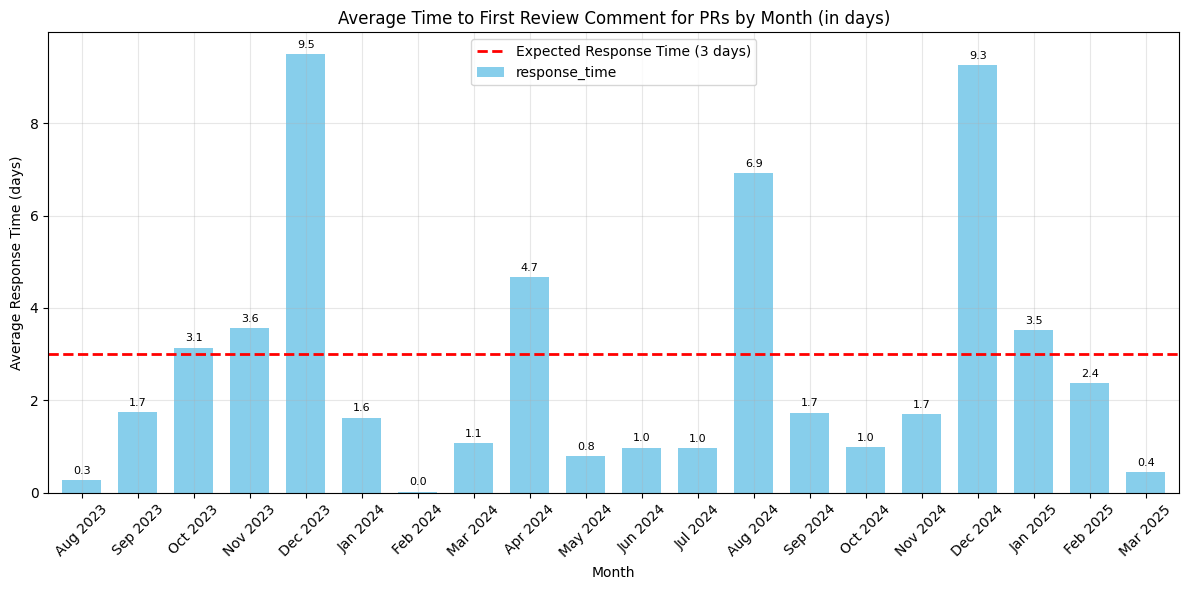

In [35]:
# Filter out rows where first_comment_at is None
df_with_comments = pd.DataFrame(prs).dropna(subset=['first_comment_at'])

# Calculate time difference between first comment and PR creation in days
df_with_comments['response_time'] = (df_with_comments['first_comment_at'] - df_with_comments['created_at']).dt.total_seconds() / (3600 * 24)

# Extract month from created_at for grouping
df_with_comments['creation_month'] = pd.to_datetime(df_with_comments['created_at']).dt.strftime('%Y-%m')

# Group by month and calculate average response time (no category grouping)
monthly_response_times = df_with_comments.groupby('creation_month')['response_time'].mean()

# Convert index to datetime for proper sorting
monthly_response_times.index = pd.to_datetime(monthly_response_times.index + '-01')
monthly_response_times = monthly_response_times.sort_index()

# Create the bar chart
plt.figure(figsize=(12, 6))
ax = monthly_response_times.plot(kind='bar', color='skyblue', width=0.7)

# Add data labels to the top of the bars
ax.bar_label(ax.containers[0], fmt='{:.1f}', padding=3, fontsize=8)

# Format x-axis labels to Month Year format
labels = [date.strftime('%b %Y') for date in monthly_response_times.index]
ax.set_xticklabels(labels)

# Add a horizontal dotted line at 3 days to show the expected response time
plt.axhline(y=3, color='r', linestyle='--', linewidth=2, label='Expected Response Time (3 days)')

plt.xlabel('Month')
plt.ylabel('Average Response Time (days)')
plt.title('Average Time to First Review Comment for PRs by Month (in days)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


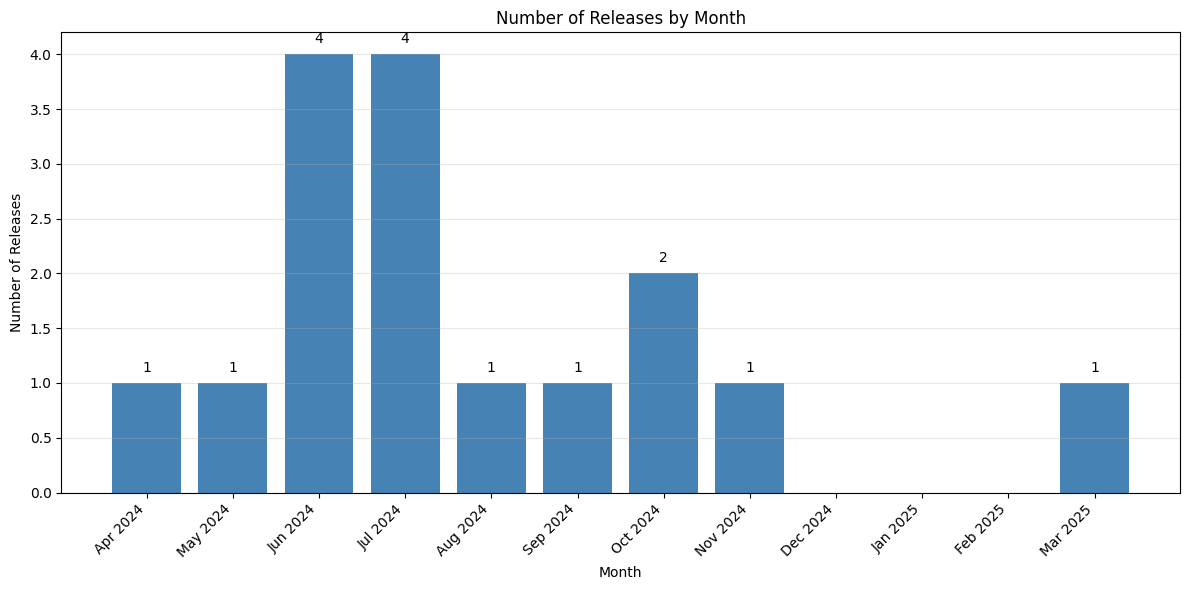

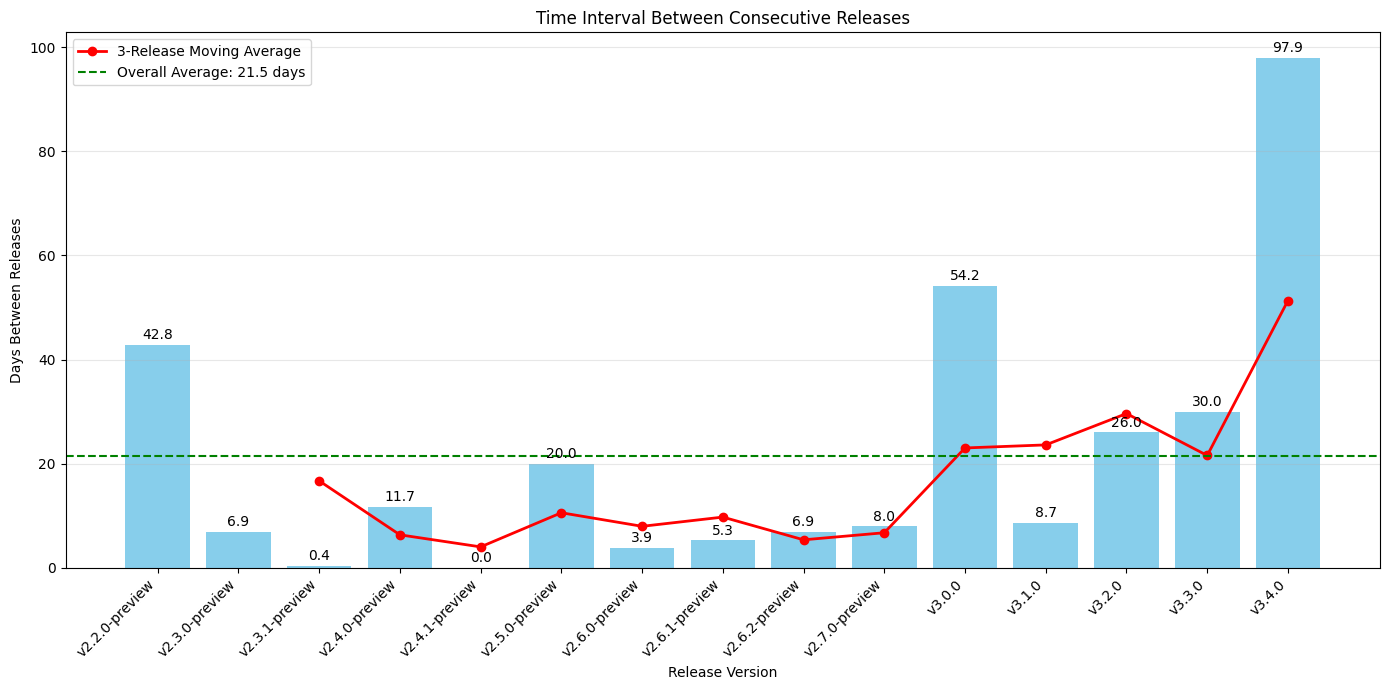

In [42]:
# Extract month and year from each release's published_at date
release_dates = []
for release in releases:
    release_dates.append({
        'month_year': release.published_at.strftime('%Y-%m'),
        'title': release.title,
        'published_at': release.published_at
    })

# Create DataFrame and count releases by month
df_releases = pd.DataFrame(release_dates)
monthly_releases = df_releases.groupby('month_year').size().reset_index(name='count')

# Convert month_year to datetime for proper sorting
monthly_releases['month_year'] = pd.to_datetime(monthly_releases['month_year'] + '-01')
monthly_releases = monthly_releases.sort_values('month_year')

# Create bar chart
plt.figure(figsize=(12, 6))
# Get the min and max dates
min_date = monthly_releases['month_year'].min()
max_date = monthly_releases['month_year'].max()

# Create a range of all months between min and max date
all_months = pd.date_range(start=min_date, end=max_date, freq='MS')
df_all_months = pd.DataFrame({'month_year': all_months})

# Left join with the original data to get counts (fills with NaN for months with no releases)
complete_df = df_all_months.merge(
    monthly_releases[['month_year', 'count']], 
    on='month_year', 
    how='left'
)

# Fill NaN values with 0 (months with no releases)
complete_df['count'] = complete_df['count'].fillna(0).astype(int)

# Plot the chart with all months
bars = plt.bar(range(len(complete_df)), complete_df['count'], color='steelblue')

# Format x-axis labels to Month Year format
plt.xticks(range(len(complete_df)), 
           [date.strftime('%b %Y') for date in complete_df['month_year']], 
           rotation=45, ha='right')

# Add data labels on bars with non-zero height
for bar in bars:
    height = bar.get_height()
    if height > 0:  # Only label non-zero bars
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
               str(int(height)), ha='center')

plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.title('Number of Releases by Month')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate time intervals between releases
intervals_days = []
release_titles = []

# Sort releases by published_at date
sorted_releases = sorted(release_dates, key=lambda x: x['published_at'])

# Calculate the intervals
for i in range(1, len(sorted_releases)):
    current = sorted_releases[i]
    previous = sorted_releases[i-1]
    interval = current['published_at'] - previous['published_at']
    # Convert to days with decimal precision
    interval_days = interval.days + interval.seconds / (24 * 3600)
    intervals_days.append(interval_days)
    release_titles.append(current['title'])

# Calculate moving average (last 3 releases)
moving_avg = []
for i in range(len(intervals_days)):
    if i < 2:  # Not enough data for 3-point average
        moving_avg.append(None)
    else:
        avg = sum(intervals_days[i-2:i+1]) / 3
        moving_avg.append(avg)

# Create the plot
plt.figure(figsize=(14, 7))
bars = plt.bar(range(len(release_titles)), intervals_days, color='skyblue')

# Add moving average line - start from the 3rd release
x_values = range(2, len(release_titles))
y_values = moving_avg[2:]  # Skip first two None values
plt.plot(x_values, y_values, 'r-', linewidth=2, 
         label='3-Release Moving Average', marker='o')

# Add average line
avg_interval_days = sum(intervals_days) / len(intervals_days)
plt.axhline(y=avg_interval_days, color='g', linestyle='--', 
           label=f'Overall Average: {avg_interval_days:.1f} days')

# Format the plot
plt.xlabel('Release Version')
plt.ylabel('Days Between Releases')
plt.title('Time Interval Between Consecutive Releases')
plt.xticks(range(len(release_titles)), release_titles, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add data labels on bars
for bar, interval in zip(bars, intervals_days):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

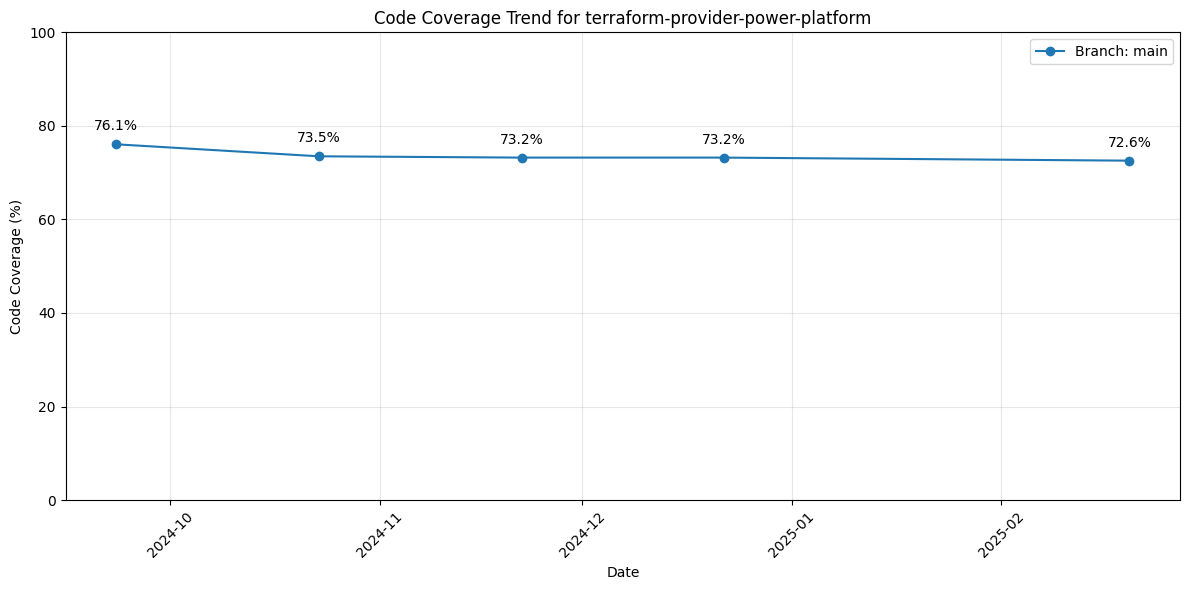

Latest coverage (2025-02-20): 72.56%


In [11]:
# Plot coverage trends
plt.figure(figsize=(12, 6))

# Group by branch and plot each as a separate line
for branch, data in df_coverage.groupby('branch'):
    line = plt.plot(data['timestamp'], data['coverage'], marker='o', label=f"Branch: {branch}")
    # Add data labels to each point
    for i, txt in enumerate(data['coverage']):
        plt.annotate(f"{txt:.1f}%", 
                    (data['timestamp'].iloc[i], data['coverage'].iloc[i]),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

plt.xlabel('Date')
plt.ylabel('Code Coverage (%)')
plt.title('Code Coverage Trend for terraform-provider-power-platform')
plt.ylim(0, 100)  # Set y-axis to show full percentage range (0-100%)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print latest coverage
latest = df_coverage.loc[df_coverage['timestamp'].idxmax()]
print(f"Latest coverage ({latest['timestamp'].strftime('%Y-%m-%d')}): {latest['coverage']:.2f}%")
